# <font  color = "#0093AF"> R$_{1\rho}$ relaxation

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter3/Ch3_R1p.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

In [1]:
# SETUP pyDR
import os
os.chdir('../..')

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
from time import time

ModuleNotFoundError: No module named 'SLEEPY'

In [2]:
delta=sl.Tools.dipole_coupling(.102,'1H','13C')
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,LF=False)
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
ex0.set_inter('CSA',i=0,delta=113,euler=[0,23*np.pi/180,0])
ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=delta,euler=[0,15*np.pi/180,0])
_=ex1.set_inter('CSA',i=0,delta=113,euler=[[0,23*np.pi/180,0],[0,55*np.pi/180,0]])

L=sl.Liouvillian(ex0,ex1,kex=sl.Tools.twoSite_kex(1e-7))

seq=L.Sequence().add_channel('15N',v1=20e3)

rho=sl.Rho('15Nx','15Nx')

<AxesSubplot:>

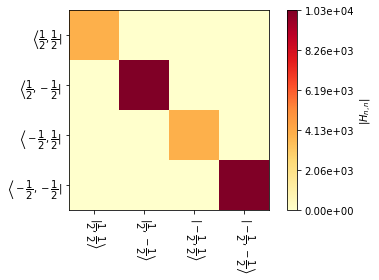

In [3]:
ex0.Hamiltonian().plot(mode='abs')

In [4]:
_=rho.DetProp(seq,n=6000)

State-space reduction: 32->16


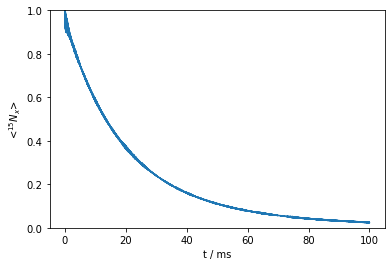

In [6]:
ax=rho.plot()
_=ax.set_ylim([0,1])

State-space reduction: 32->8
State-space reduction: 32->8


<AxesSubplot:xlabel='t / ms', ylabel='<$^{15}N_x$>'>

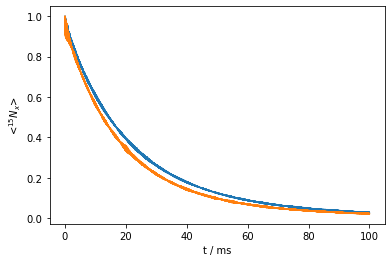

In [7]:
rho=sl.Rho(2*ex0.Op[0].x@ex0.Op[1].alpha,'15Nx')
rho.DetProp(seq,n=6000)
ax=rho.plot()
rho=sl.Rho(2*ex0.Op[0].x@ex0.Op[1].beta,'15Nx')
rho.DetProp(seq,n=6000)
_=rho.plot(ax=ax)

In [8]:
rho=[]
for v1 in np.linspace(10e3,50e3,4):
    rho.append(sl.Rho('15Nx','15Nx'))
    seq.add_channel('15N',v1=v1)
    rho[-1].DetProp(seq,n=6000)

State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16


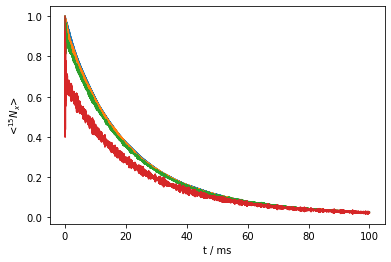

In [9]:
ax=plt.subplots()[1]
for rho0 in rho:rho0.plot(ax=ax)

In [10]:
L.kex=sl.Tools.twoSite_kex(1e-5)
rho=[]
for v1 in np.linspace(10e3,50e3,4):
    rho.append(sl.Rho('15Nx','15Nx'))
    seq.add_channel('15N',v1=v1)
    rho[-1].DetProp(seq,n=6000)

State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16


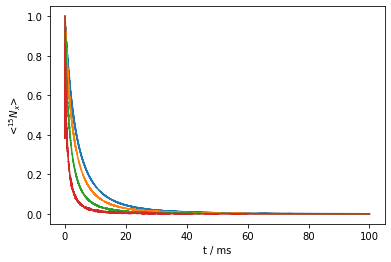

In [11]:
ax=plt.subplots()[1]
for rho0 in rho:rho0.plot(ax=ax)

In [13]:
sl.Defaults['verbose']=False
tc0=np.logspace(-8,-4,41)
v10=[10e3,25e3,40e3,55e3]
R1p={v1:np.zeros(tc0.shape) for v1 in v10}
rho=sl.Rho('15Nx','15Nx')

t0=time()
for k,tc in enumerate(tc0):
    L.kex=sl.Tools.twoSite_kex(tc=tc)
    for v1 in v10:
        seq.add_channel('15N',v1=v1)
        R1p[v1][k]=rho.extract_decay_rates(seq,pwdavg=True)
    if np.mod(k,10)==0:
        print(f'log10(tc)={np.log10(tc):.1f}, {time()-t0:.0f} seconds elapsed')

log10(tc)=-8.0, 17 seconds elapsed
log10(tc)=-7.0, 183 seconds elapsed
log10(tc)=-6.0, 322 seconds elapsed
log10(tc)=-5.0, 454 seconds elapsed
log10(tc)=-4.0, 583 seconds elapsed


Text(0, 0.5, '$R_{1\\rho}$ / s$^{-1}$')

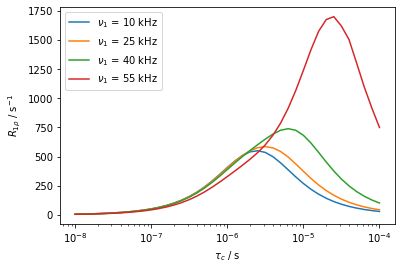

In [14]:
ax=plt.subplots()[1]
for v1 in v10:
    ax.semilogx(tc0,R1p[v1],label=fr'$\nu_1$ = {v1/1e3:.0f} kHz')
ax.legend()
ax.set_xlabel(r'$\tau_c$ / s')
ax.set_ylabel(r'$R_{1\rho}$ / s$^{-1}$')